In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import hashlib

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [6]:
data_directory = "data/"
cat_types = os.listdir(data_directory)
print(f"Number of cat types: {len(cat_types)}")
print(f"Cat types: {', '.join(cat_types)}")

Number of cat types: 7
Cat types: african-wildcat, blackfoot-cat, chinese-mountain-cat, domestic-cat, european-wildcat, jungle-cat, sand-cat


In [7]:
for cat_type in cat_types:
    cat_images = os.listdir(data_directory + cat_type)
    print(f"Number of images for {cat_type}: {len(cat_images)}")

Number of images for african-wildcat: 91
Number of images for blackfoot-cat: 79
Number of images for chinese-mountain-cat: 41
Number of images for domestic-cat: 64
Number of images for european-wildcat: 71
Number of images for jungle-cat: 86
Number of images for sand-cat: 73


In [8]:
image_sizes = []
for cat_type in cat_types:
    cat_images = os.listdir(data_directory + cat_type)
    for cat_image in cat_images:
        if cat_image.endswith(".jpg"):
            with Image.open(data_directory + cat_type + "/" + cat_image) as img:
                image_sizes.append(img.size)
# print(f"Image Sizes: {image_sizes}")
print(f"Median Image Size: {np.median(image_sizes, axis=0)}")
print(f"Median image width: {np.median([size[0] for size in image_sizes])}")
print(f"Median image height: {np.median([size[1] for size in image_sizes])}")

Median Image Size: [274.5 194. ]
Median image width: 274.5
Median image height: 194.0


Text(0.5, 1.0, 'Image Size (width/height)')

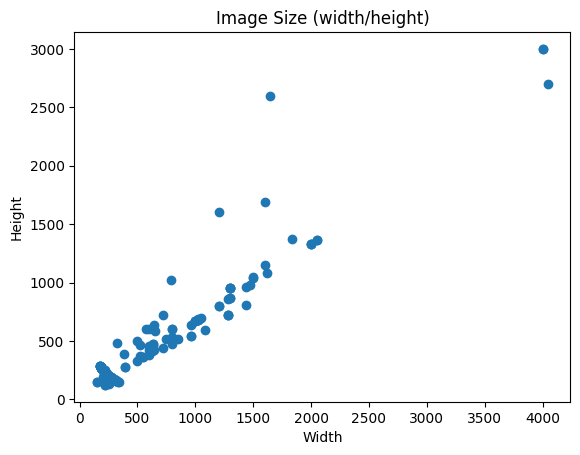

In [9]:
width = [size[0] for size in image_sizes]
height = [size[1] for size in image_sizes]
plt.scatter(width, height)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size (width/height)")

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [10]:
hashes = []
for cat_type in cat_types:
    cat_images = os.listdir(data_directory + cat_type)
    for cat_image in cat_images:
        if cat_image.endswith(".jpg"):
            with open(data_directory + cat_type + "/" + cat_image, "rb") as img:
                image_hash = hashlib.md5(img.read()).hexdigest()
                img.close()
                if image_hash in hashes:
                    print(f"Found duplicate: {cat_image}")
                    os.remove(data_directory + cat_type + "/" + cat_image)
                    print(f"Removed: {cat_image}")
                else:
                    hashes.append(image_hash)

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [11]:
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import tensorflow as tf

model = tf.keras.applications.ResNet50(weights='imagenet')

model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
model_layers = len(model.layers)
print(f"Model Layers: {model_layers}")

Model Layers: 177


In [14]:
model_parameters = model.count_params()
print(f"Model Parameters: {model_parameters}")

Model Parameters: 25636712


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [15]:
image = tf.keras.utils.load_img("data/african-wildcat/af (1).jpg", target_size=(224, 224))

In [16]:
for cat_type in cat_types:
    cat_images = os.listdir(data_directory + cat_type)
    for cat_image in cat_images:
        if cat_image.endswith(".jpg"):
            image_path = data_directory + cat_type + "/" + cat_image
            image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.utils.img_to_array(image)
            image_array = np.expand_dims(image_array, axis=0)

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [21]:
import os
preprocessed_images_directory = "preprocessed_images/"
os.makedirs(preprocessed_images_directory, exist_ok=True)
for cat_type in cat_types:
    print(cat_type)
    cat_images = os.listdir(data_directory + cat_type)
    for cat_image in cat_images:
        print(cat_image)
        if cat_image.endswith(".jpg"):
            image_path = data_directory + cat_type + "/" + cat_image
            image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.utils.img_to_array(image)
            image_array = np.expand_dims(image_array, axis=0)
            save_path = os.path.join(preprocessed_images_directory, cat_type)
            os.makedirs(save_path, exist_ok=True)
            npy_filename = os.path.join(save_path, cat_image.replace(".jpg", ".npy"))
            np.save(npy_filename, image_array)
            print(f"Saved: {npy_filename}")

african-wildcat
af (1).jpg
Saved: preprocessed_images/african-wildcat\af (1).npy
af (10).jpg
Saved: preprocessed_images/african-wildcat\af (10).npy
af (11).jpg
Saved: preprocessed_images/african-wildcat\af (11).npy
af (12).jpg
Saved: preprocessed_images/african-wildcat\af (12).npy
af (13).jpg
Saved: preprocessed_images/african-wildcat\af (13).npy
af (14).jpg
Saved: preprocessed_images/african-wildcat\af (14).npy
af (15).jpg
Saved: preprocessed_images/african-wildcat\af (15).npy
af (16).jpg
Saved: preprocessed_images/african-wildcat\af (16).npy
af (17).jpg
Saved: preprocessed_images/african-wildcat\af (17).npy
af (18).jpg
Saved: preprocessed_images/african-wildcat\af (18).npy
af (19).jpg
Saved: preprocessed_images/african-wildcat\af (19).npy
af (2).jpg
Saved: preprocessed_images/african-wildcat\af (2).npy
af (20).jpg
Saved: preprocessed_images/african-wildcat\af (20).npy
af (21).jpg
Saved: preprocessed_images/african-wildcat\af (21).npy
af (22).jpg
Saved: preprocessed_images/african-wil

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [23]:
all_images = []
for cat_type in cat_types:
    cat_images_path = os.path.join(preprocessed_images_directory, cat_type)
    cat_images = os.listdir(cat_images_path)
    for cat_image in cat_images:
        if cat_image.endswith(".npy"):
            image = np.load(os.path.join(cat_images_path, cat_image))
            all_images.append(image)

all_images = np.vstack(all_images)
predictions = model.predict(all_images)
predicted_classes = np.argmax(predictions, axis=1)

decoded_predictions = tf.keras.applications.resnet50.decode_predictions(predictions, top=1)

for i, pred in enumerate(decoded_predictions):
    print(f"Image {i}: Predicted as {pred[0][1]} with confidence {pred[0][2]:.2f}")
    

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 953ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
Image 0: Predicted as lynx with confidence 0.99
Image 1: Predicted as tabby with confidence 0.31
Image 2: Predicted as lynx with confidence 0.83
Image 3: Predicted as lynx with confidence 0.83
Image 4: Predicted as lynx with confidence 0.41
Image 5: Predicted as Egyptian_cat with confidence 0.69
Image 6: Predicted as coyote with confidence 0.88
Image 7: Predicted as white_wolf with confidence 0.26
Image 8: Predicted as web_site with confidence 0.28
Image 9: Predicted as lynx with confidence 0.91
Image 10: Predicted as lynx with confidence 0.30
Image 11: Predicted as Egyptian_cat with confidence 0.48
Image 12: Predicted as tabby with confidence 0.31
Image 13: Predicted as tiger with confidence 0.56
Image 14: Predicted as lynx with confidence 0.46
Image 15: Predicted as lynx with confidence 0.84
Image 16: Predicted as coyote with confidence 0.80
Image 17: Predicted as Egyptian_cat with confidence 0.23


In [24]:
print(decoded_predictions)

[[('n02127052', 'lynx', 0.9867172)], [('n02123045', 'tabby', 0.3090728)], [('n02127052', 'lynx', 0.8288912)], [('n02127052', 'lynx', 0.82818687)], [('n02127052', 'lynx', 0.41344136)], [('n02124075', 'Egyptian_cat', 0.68808883)], [('n02114855', 'coyote', 0.8818858)], [('n02114548', 'white_wolf', 0.2604023)], [('n06359193', 'web_site', 0.28221175)], [('n02127052', 'lynx', 0.9110814)], [('n02127052', 'lynx', 0.29859746)], [('n02124075', 'Egyptian_cat', 0.47718066)], [('n02123045', 'tabby', 0.31492874)], [('n02129604', 'tiger', 0.558454)], [('n02127052', 'lynx', 0.4588192)], [('n02127052', 'lynx', 0.83803684)], [('n02114855', 'coyote', 0.79673505)], [('n02124075', 'Egyptian_cat', 0.22959076)], [('n02127052', 'lynx', 0.8714345)], [('n02114855', 'coyote', 0.1651189)], [('n02127052', 'lynx', 0.60230625)], [('n02447366', 'badger', 0.30341578)], [('n02127052', 'lynx', 0.34987608)], [('n02123045', 'tabby', 0.5055395)], [('n02127052', 'lynx', 0.7305283)], [('n02114855', 'coyote', 0.1606631)], [('

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [30]:
import os
import numpy as np
import tensorflow as tf
from skimage.color import rgb2gray

all_images_gray = []
for cat_type in cat_types:
    cat_images_path = os.path.join(preprocessed_images_directory, cat_type)
    cat_images = os.listdir(cat_images_path)
    for cat_image in cat_images:
        if cat_image.endswith(".npy"):
            image = np.load(os.path.join(cat_images_path, cat_image))
            image = np.squeeze(image, axis=0)  
            
            image_gray = rgb2gray(image)
            
            image_gray = np.expand_dims(image_gray, axis=-1)
            
            image_gray = np.repeat(image_gray, 3, axis=-1)
            
            image_gray = tf.keras.applications.resnet50.preprocess_input(image_gray)
            
            all_images_gray.append(image_gray)
            
all_images_gray = np.array(all_images_gray)
print("Shape of the input array:", all_images_gray.shape) 

predictions_gray = model.predict(all_images_gray)

predicted_classes_gray = np.argmax(predictions_gray, axis=1)

decoded_predictions_gray = tf.keras.applications.resnet50.decode_predictions(predictions_gray, top=1)

for i, pred in enumerate(decoded_predictions_gray):
    print(f"Image {i}: Predicted as {pred[0][1]} with confidence {pred[0][2]:.2f}")


Shape of the input array: (504, 224, 224, 3)
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 869ms/step
Image 0: Predicted as lynx with confidence 0.92
Image 1: Predicted as tabby with confidence 0.34
Image 2: Predicted as lynx with confidence 0.58
Image 3: Predicted as lynx with confidence 0.99
Image 4: Predicted as lynx with confidence 0.40
Image 5: Predicted as Egyptian_cat with confidence 0.66
Image 6: Predicted as grey_fox with confidence 0.57
Image 7: Predicted as Egyptian_cat with confidence 0.25
Image 8: Predicted as coyote with confidence 0.32
Image 9: Predicted as lynx with confidence 0.91
Image 10: Predicted as lynx with confidence 0.43
Image 11: Predicted as lynx with confidence 0.42
Image 12: Predicted as tiger_cat with confidence 0.49
Image 13: Predicted as tiger_cat with confidence 0.27
Image 14: Predicted as lynx with confidence 0.28
Image 15: Predicted as lynx with confidence 0.84
Image 16: Predicted as coyote with confidence 0.65
Image 17: Predicted as tabby with confidence 0.49
Image

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.